如果在阅读相关文档后仍然存在疑惑，可以加入nncase讨论群：`790699378`，或者在nncase的github仓库提问题[click here](https://github.com/kendryte/nncase/issues)。

# 1. nncase安装和环境设置

In [ ]:
!pip install --upgrade pip
!pip install nncase --timeout=1000
!pip install nncase-kpu --timeout=1000
!pip install onnx onnxsim scikit-learn

# nncase-2.x need dotnet-7
# Ubuntu use apt to install dotnet-7.0 (The docker has installed dotnet7.0)
!sudo apt-get install -y dotnet-sdk-7.0

## 自动设置环境变量

In [ ]:
import os
import sys
import subprocess

result = subprocess.run(["pip", "show", "nncase"], capture_output=True)

split_flag = "\n"
if sys.platform == "win32":
    split_flag = "\r\n"
    
location_s = [i for i in result.stdout.decode().split(split_flag) if i.startswith("Location:")]
location = location_s[0].split(": ")[1]

if "PATH" in os.environ:
    os.environ["PATH"] += os.pathsep + location
else:
    os.environ["PATH"] = location


# 2. 设置编译选项和量化选项

你可以在下面的链接中找到参数的详细描述 [preprocess args](https://github.com/kendryte/nncase/blob/master/docs/USAGE_v2_EN.md#CompileOptions)，[quantize options](https://github.com/kendryte/nncase/blob/master/docs/USAGE_v2_EN.md#PTQTensorOptions)，[Mix quantize](https://github.com/kendryte/nncase/blob/master/docs/MixQuant.md)。

In [ ]:
import nncase
import numpy as np
from nncase_base_func import *

def compile_kmodel(model_path, dump_path, calib_data):
    """
    Set compile options and ptq options.
    Compile kmodel.
    Dump the compile-time result to 'compile_options.dump_dir'
    """
    print("\n----------   compile    ----------")
    print("Simplify...")
    model_file = model_simplify(model_path)

    print("Set options...")
    # import_options
    import_options = nncase.ImportOptions()

    ############################################
    # 你需要修改下面这段代码中的参数来适配你的模型。
    # 详细的说明可以参考docs/USAGE_v2.md.
    ############################################
    # compile_options
    compile_options = nncase.CompileOptions()
    compile_options.target = "k230" #"cpu"
    compile_options.dump_ir = True  # if False, will not dump the compile-time result.
    compile_options.dump_asm = True
    compile_options.dump_dir = dump_path
    compile_options.input_file = ""
    
    # preprocess args
    compile_options.preprocess = False
    if compile_options.preprocess:
        compile_options.input_type = "uint8" # "uint8" "float32"
        compile_options.input_shape = [1,224,320,3]
        compile_options.input_range = [0,1]
        compile_options.input_layout = "NHWC" # "NHWC"
        compile_options.swapRB = False
        compile_options.mean = [0,0,0]
        compile_options.std = [1,1,1]
        compile_options.letterbox_value = 0
        compile_options.output_layout = "NHWC" # "NHWC"

    # quantize options
    ptq_options = nncase.PTQTensorOptions()
    ptq_options.quant_type = "uint8" # datatype : "float32", "int8", "int16"
    ptq_options.w_quant_type = "uint8"  # datatype : "float32", "int8", "int16"
    ptq_options.calibrate_method = "NoClip" # "Kld"
    ptq_options.finetune_weights_method = "NoFineTuneWeights"
    ptq_options.dump_quant_error = False
    ptq_options.dump_quant_error_symmetric_for_signed = False

    # mix quantize options
    # more details in docs/MixQuant.md
    ptq_options.quant_scheme = ""
    ptq_options.quant_scheme_strict_mode = False
    ptq_options.export_quant_scheme = False
    ptq_options.export_weight_range_by_channel = False
    ############################################
    
    ptq_options.samples_count = len(calib_data[0])
    ptq_options.set_tensor_data(calib_data)
    
    print("Compiling...")
    compiler = nncase.Compiler(compile_options)
    # import
    model_content = read_model_file(model_file)
    if model_path.split(".")[-1] == "onnx":
        compiler.import_onnx(model_content, import_options)
    elif model_path.split(".")[-1] == "tflite":
        compiler.import_tflite(model_content, import_options)
    
    compiler.use_ptq(ptq_options)
    
    # compile
    compiler.compile()
    kmodel = compiler.gencode_tobytes()
    
    kmodel_path = os.path.join(dump_path, "test.kmodel")
    with open(kmodel_path, 'wb') as f:
        f.write(kmodel)
    print("----------------end-----------------")
    return kmodel_path


# 3. 编译单输入模型
在开始之前，我们需要获取模型的输入输出信息。<br>
使用[netron](https://netron.app)进行模型可视化，将你的模型直接拖入网页即可。<br>
点击任意输入节点就可以在右侧看到模型所有的输入输出节点信息。<br>
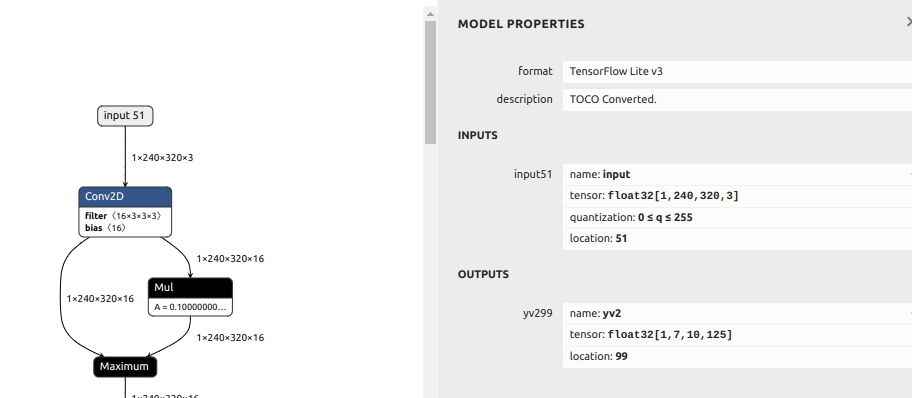 <br>

在编译`kmodel`之前，我们需要设置`CompileOptions` 和 `PTQTensorOptions`来指定`kmodel`的各个属性。<br>

然后需要设置`model_path`, `dump_path`, and `calib_data`。 <br>
校正集数据的格式为：`[[x1, x2,...]]`。 <br>

In [ ]:
# compile kmodel single input
model_path = "./test.tflite"
dump_path = "./tmp_tflite"

# 校正集的数量为2
calib_data = [[np.random.rand(1, 240, 320, 3).astype(np.float32), np.random.rand(1, 240, 320, 3).astype(np.float32)]]

kmodel_path = compile_kmodel(model_path, dump_path, calib_data)


# 4. PC上推理单输入kmodel
需要设置 `kmodel_path` 和 `input_data`。执行完毕以后，会打印出每个输出结果的shape信息，同时输出结果会保存到`dump_path`目录下。

In [ ]:
# run kmodel(simulate)
import os

kmodel_path = "./tmp_tflite/test.kmodel"
input_data = [np.random.rand(1, 240, 320, 3).astype(np.float32)]

result = run_kmodel(kmodel_path, input_data)

for idx, i in enumerate(result):
    print(i.shape)
    i.tofile(os.path.join(dump_path,"nncase_result_{}.bin".format(idx)))

# 5. 比较TF结果和kmodel的推理结果

这里，我们使用TensorFlow框架来推理`.tflite`模型，然后计算TensorFlow输入结果和kmodel的输出结果的余弦。

>如果你在编译`kmodel`时使用了前处理相关的配置，当你需要使用`ONNX`或者`TFLite`框架进行结果验证时，需要在你的`ONNX`或者`TFLite` pipeline中增加相应的前处理操作，这样才能保证和`kmodel` pipeline是等价的。

In [ ]:
!pip install tensorflow
import tensorflow as tf
interp = tf.lite.Interpreter(model_path=model_path)

inputs = []
for idx, item in enumerate(interp.get_input_details()):
    input_dict = {}
    input_dict['index'] = item['index']
    input_dict['value'] = input_data[idx]
    inputs.append(input_dict)
    
# print(input_dict)

interp.allocate_tensors()
for input in inputs:
    interp.set_tensor(input['index'], input['value'])
interp.invoke()

tflite_result = []
for item in interp.get_output_details():
    tflite_result.append(interp.get_tensor(item['index']))

for index, (i, j) in enumerate(zip(tflite_result, result)):
    print("result {} cosine = ".format(index), get_cosine(i, j))


# 6. 编译多输入模型

在阅读 [编译单输入模型](#编译单输入模型)之后,你已经清楚了如何设置单输入模型的校正集。<br>
这里我们会介绍如何设置多输入模型的校正集。<br>

如果模型存在多个输入，那么校正集的格式就是`[[x1, x2,...], [y1, y2,...], ...]`。 <br>

```
例如，模型有三个输入，分别是(x, y, z)，并且这三个输入的详细信息如下：
x:{shape: [3,100], range: [1,5], dtype: int64}
y:{shape: [100, 3, 192], range: [0,1), dtype: float32}
z:{shape: [3,100], dtype: bool}

那么校正集就是下面这个样子：
calib_data = [
[ np.random.randint(1, 5, size=[3,100], dtype='int64'), np.random.randint(1, 5, size=[3,100], dtype='int64')],
[ np.random.rand(100, 3, 192).astype(np.float32), np.random.rand(100, 3, 192).astype(np.float32)],
[ np.random.rand(3,100).astype(np.float32)>0.5, np.random.rand(3,100).astype(np.float32)>0.5],] # bool

如果你numpy有一些使用经验，想必你在看到这里已经知道如何设置正确的数据了。
```

下面，我们用一个简单一点的模型来运行个示例，模型结构如下所示。

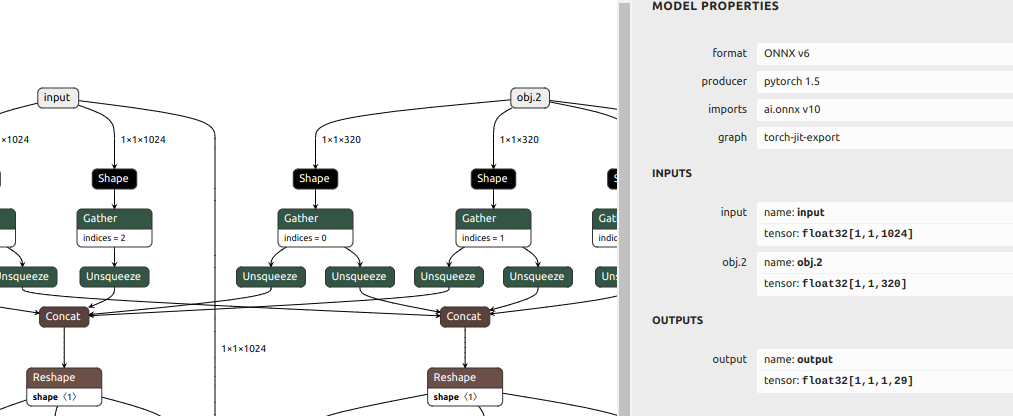


In [ ]:
# compile kmodel multiple inputs
model_path = "./test.onnx"
dump_path = "./tmp_onnx"

# 校正集的数量为2
calib_data = [[np.random.rand(1, 1, 1024).astype(np.float32), np.random.rand(1, 1, 1024).astype(np.float32)],
              [np.random.rand(1, 1, 320).astype(np.float32), np.random.rand(1, 1, 320).astype(np.float32)]]

kmodel_path = compile_kmodel(model_path, dump_path, calib_data)



# 7. PC上推理多输入kmodel

In [ ]:
# run kmodel(simulate)
import os

kmodel_path = "./tmp_onnx/test.kmodel"
input_data = [np.random.rand(1, 1, 1024).astype(np.float32), np.random.rand(1, 1, 320).astype(np.float32)]

results = run_kmodel(kmodel_path, input_data)

for idx, i in enumerate(results):
    print(i.shape)
    i.tofile(os.path.join(dump_path,"nncase_result_{}.bin".format(idx)))


# 8. 比较ONNX结果和kmodel推理结果

这里给出如何调用ONNX框架推理的示例代码，以及如何将ONNX的推理结果和kmodel的推理结果进行比较，该比较结果为余弦值的形式。

> 如果你在编译`kmodel`时使用了前处理相关的配置，当你需要使用`ONNX`或者`TFLite`框架进行结果验证时，需要在你的`ONNX`或者`TFLite` pipeline中增加相应的前处理操作，这样才能保证和`kmodel` pipeline是等价的。

In [ ]:
!pip install onnxruntime
import onnxruntime as rt

onnx_model = model_simplify(model_path)
onnx_model = model_path
_, input_info = parse_model_input_output(model_path)
onnx_sess = rt.InferenceSession(onnx_model)

input_dict = {}
for i, info in enumerate(input_info):
    print(info['shape'])
    input_dict[info["name"]] = input_data[i]

onnx_results = onnx_sess.run(None, input_dict)
for index, (i, j) in enumerate(zip(onnx_results, results)):
    print("result {} cosine = ".format(index), get_cosine(i, j))